Link to website: https://albert-moller.github.io

Link to explainer notebook: https://github.com/albert-moller/albert-moller.github.io

Group members: Albert Frisch Møller (s214610) and Mark Andrawes (s214654)

For this final assignment each group member contributed equally to every aspect of the assignment

### Explainer Notebook

##### Motivation

##### Basic stats

##### Tools, theory and analysis 

In [1]:
from datasets import load_dataset, concatenate_datasets
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import netwulf as nw

/Users/albertmoller/anaconda3/envs/comsocsci2024/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = load_dataset('m-newhauser/senator-tweets')
datasets_to_combine = [dataset[split] for split in dataset.keys()]
combined_dataset = concatenate_datasets(datasets_to_combine)
df = combined_dataset.to_pandas()

In [3]:
#Find number of unique senators and mentions
unique_usernames = set(df['username'].unique())

valid_mentions_count = 0
for index, row in df.iterrows():
    text = row['text']
    tokens = text.split('@')[1:]
    for token in tokens:
        potential_username = token.split()[0] if ' ' in token else token
        if potential_username in unique_usernames:
            valid_mentions_count += 1

print(f"Number of senators: {len(unique_usernames)}")
print(f"Number of valid mentions: {valid_mentions_count}")

Number of senators: 99
Number of valid mentions: 4744


In [4]:
#Build the US Senate twitter network

G = nx.Graph()
edges = defaultdict(int)

for index, row in df.iterrows():
    sender = row['username']
    text = row['text']
    unique_usernames = set(df['username'].unique())
    
    tokens = text.split('@')[1:] 
    
    for token in tokens:
        potential_username = token.split()[0] if ' ' in token else token
        if potential_username in unique_usernames and potential_username != sender:
            edge = tuple(sorted((sender, potential_username)))
            edges[edge] += 1

for (source, target), weight in edges.items():
    G.add_edge(source, target, weight=weight)

#Add party attribute to each node
for node in G.nodes:
    party = df[df['username'] == node]['party'].values[0]
    G.nodes[node]['party'] = party

In [5]:
node_count_real = G.number_of_nodes()
edge_count_real = G.number_of_edges()

print(f"Number of nodes: {node_count_real}")
print(f"Number of edges: {edge_count_real}")

#Calculate p using the formula p = 2*<L>/(N*(N-1)) obtained by isolating for p in equation 3.2 from Chapter 3
p = 2 * edge_count_real / (node_count_real*(node_count_real-1))
print(f"Probability p is {p}")

#Calculate the average degree using the formula <k> = p*(N-1) (equation 3.3 from Chapter 3)
average_degree = p*(node_count_real-1)
print(f"Average degree <k> is {average_degree}")


Number of nodes: 99
Number of edges: 1608
Probability p is 0.33147804576376005
Average degree <k> is 32.484848484848484


In [6]:
def random_network(N, p):
    G = nx.Graph()
    G.add_nodes_from(range(N))
    for i in range(N):
        for j in range(i+1,N):
            if np.random.uniform(0,1) < p:
                G.add_edge(i,j)
    return G

G_random = random_network(node_count_real, p)

In [7]:
#Visualizing the networks
nw.visualize(G)
nw.visualize(G_random)

(None, None)

In [8]:
connected_components = list(nx.connected_components(G_random))
largest_connected_component = max(connected_components, key = len)
largest_subgraph_random = G_random.subgraph(largest_connected_component)

connected_components = list(nx.connected_components(G))
largest_connected_component = max(connected_components, key = len)
largest_subgraph_real = G.subgraph(largest_connected_component)

#Compute size of the largest connected component of random network.
print(f"Size of the largest connected component (random network) is {largest_subgraph_random.number_of_nodes()}")

#Compute size of the largest connected component of real network.
print(f"Size of the largest connected component (real network) is {largest_subgraph_real.number_of_nodes()}")

#Compute the number of isolated components for the random network
isolated_n = list(nx.isolates(G_random))
number_of_isolated_nodes = len(isolated_n)
print(f"Number of isolated nodes in the random network: {number_of_isolated_nodes}")

#Compute the number of isolated components for the real network
isolated_n = list(nx.isolates(G))
number_of_isolated_nodes = len(isolated_n)
print(f"Number of isolated nodes in the real network: {number_of_isolated_nodes}")




Size of the largest connected component (random network) is 99
Size of the largest connected component (real network) is 99
Number of isolated nodes in the random network: 0
Number of isolated nodes in the real network: 0


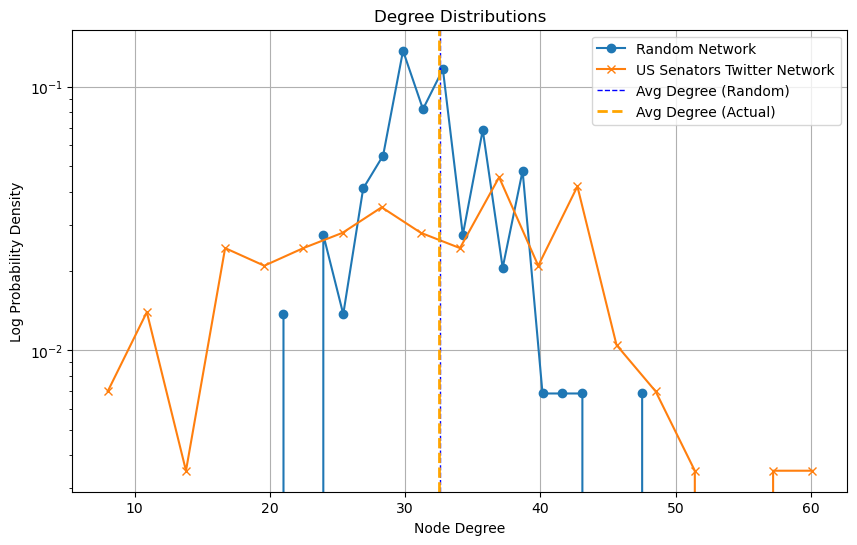

In [9]:
import matplotlib.pyplot as plt

#Compute degree distribution for the random network:
node_degrees_random = [degree for node, degree in G_random.degree()]
max_node_degree = max(node_degrees_random)
min_node_degree = min(node_degrees_random)
bins = np.linspace(min_node_degree, max_node_degree, 20)
degree_distribution_random, edges_random = np.histogram(node_degrees_random, bins=bins, density=True)

#Compute degree distribution for the real Computational Social Scientists network:
node_degrees_real = [degree for node, degree in G.degree()]
max_node_degree = max(node_degrees_real)
min_node_degree = min(node_degrees_real)
bins = np.linspace(min_node_degree, max_node_degree, 20)
degree_distribution_real, edges_real = np.histogram(node_degrees_real, bins=bins, density=True)

# Plot both degree distributions on the same figure using line plots
plt.figure(figsize=(10, 6))
plt.plot(edges_random[:-1], degree_distribution_random, linestyle='-', marker='o', label='Random Network')
plt.plot(edges_real[:-1], degree_distribution_real, linestyle='-', marker='x', label='US Senators Twitter Network')
avg_degree_random = np.mean(node_degrees_random)
avg_degree_actual = np.mean(node_degrees_real)
plt.axvline(avg_degree_random, color='blue', linestyle='dashed', linewidth=1, label='Avg Degree (Random)')
plt.axvline(avg_degree_actual, color='orange', linestyle='dashed', linewidth=2, label='Avg Degree (Actual)')
plt.xlabel('Node Degree')
plt.ylabel('Log Probability Density')
#plt.xscale('log')
plt.yscale('log')
plt.title('Degree Distributions')
plt.legend()
plt.grid(True)

In [11]:
def assortativity_coeffecient(G, attribute: str):
    attribute_dict = nx.get_node_attributes(G, attribute)
    assert len(attribute_dict) == G.number_of_nodes()
    attributes = list(set(attribute_dict.values()))
    attribute_indices = {attr: i for i, attr in enumerate(attributes)}
    e = np.zeros((len(attributes), len(attributes)))

    for a, b in G.edges():
        index_a = attribute_indices[attribute_dict[a]]
        index_b = attribute_indices[attribute_dict[b]]
        e[index_a][index_b] += 1
        e[index_b][index_a] += 1
    
    e = e / e.sum()
    a, b = e.sum(axis=1), e.sum(axis=0)
    r = (np.sum(np.diag(e)) - np.sum(a * b)) / (1 - np.sum(a * b))
    return r 
        
r = assortativity_coeffecient(G, "party")
print("Assortativity coefficient based on country:", round(r,3))

Assortativity coefficient based on country: 0.262
